In [1]:
import numpy as np
import datasets
import tensorflow as tf
from tensorflow.keras import activations, layers, models
import matplotlib.pyplot as plt
from parameters import Parameters
import convtas
from loss import LOGL2,SDR
import os
import musdb


First thing we are going to do is to just load our data in. The data when being put through a TensorFlow should be organized in a very specific way. Right now each observation in our data is organized like this : $(2\cdot M,K,L)$

- $M$ = 100; Batch number, remember each batch observation is 2 tensors each one correlating to the left/right audio channel.
- $K$ = 40; Index/number of overlapping chunks of waveform.
- $L$ = 16; Length of a chunk/sample of data. For this study we will refer to these as chunks.

For our outputs the data is structured like: $(2\cdot M,C,K,L)$

- $C$ = 4; Denotes the source target.

In [3]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [4]:
def make_med_dataset():
    datasets = [tf.data.Dataset.load(f'tensors/tensor_dataset_small_{i}') for i in range(10)]

    for i, data in enumerate(datasets):
        if i == 0:
            dataset = data
        else: 
            dataset = dataset.concatenate(data)
    
    dataset.save('tensors/tensor_dataset_medium')

make_med_dataset()

In [2]:
dataset = tf.data.Dataset.load(f'tensors/tensor_dataset_medium')

In [6]:
print(tf.data.experimental.cardinality(dataset).numpy())

4000


In [42]:
param = Parameters()

In [43]:
cnn = convtas.ConvTasNet(param)

In [3]:
def run_model(model, loss: str, loss_funct, dataset, epochs=10):
    # Create a callback that saves the model's weights every 5 epochs
    checkpoint_path = f"training_{loss}_2/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=True,
                                                    verbose=1)
    
    model.compile(optimizer='adam',
              loss=loss_funct,
              metrics=['accuracy']
              )
    
    history = model.fit(dataset, epochs=epochs, callbacks=[cp_callback])

    return history

def create_fit_save(dataset, epochs=10):
    param = Parameters()
    cnn = convtas.ConvTasNet(param)
    cnn.load_weights("training_LOGL2_2/cp.ckpt")
    hist1 = run_model(cnn, "LOGL2", LOGL2(), dataset, epochs=8)
    cnn = convtas.ConvTasNet(param)
    hist2 = run_model(cnn, "SDR", SDR(), dataset)
    
    return hist1, hist2
    


In [4]:
create_fit_save(dataset)

Epoch 1/8
4000/4000 [==============================] - ETA: 0s - loss: 1.4906 - accuracy: 0.3134
Epoch 1: saving model to training_LOGL2_2\cp.ckpt
4000/4000 [==============================] - 2900s 717ms/step - loss: 1.4906 - accuracy: 0.3134
Epoch 2/8
4000/4000 [==============================] - ETA: 0s - loss: 1.4869 - accuracy: 0.3145
Epoch 2: saving model to training_LOGL2_2\cp.ckpt
4000/4000 [==============================] - 2887s 722ms/step - loss: 1.4869 - accuracy: 0.3145
Epoch 3/8
4000/4000 [==============================] - ETA: 0s - loss: 1.4835 - accuracy: 0.3158
Epoch 3: saving model to training_LOGL2_2\cp.ckpt
4000/4000 [==============================] - 2891s 723ms/step - loss: 1.4835 - accuracy: 0.3158
Epoch 4/8
4000/4000 [==============================] - ETA: 0s - loss: 1.4802 - accuracy: 0.3164
Epoch 4: saving model to training_LOGL2_2\cp.ckpt
4000/4000 [==============================] - 2889s 722ms/step - loss: 1.4802 - accuracy: 0.3164
Epoch 5/8
4000/4000 [=======

KeyboardInterrupt: 

In [7]:
cnn.compile(optimizer='adam',
              loss=SDR(),
              metrics=['accuracy']
              )

In [8]:
history = cnn.fit(dataset, epochs=10)

Epoch 1/10
400/400 [==============================] - 1168s 3s/step - loss: -2.3059 - accuracy: 0.1951
Epoch 2/10
400/400 [==============================] - 1174s 3s/step - loss: -2.8136 - accuracy: 0.2347
Epoch 3/10
 74/400 [====>.........................] - ETA: 3:41 - loss: -2.9191 - accuracy: 0.2421

KeyboardInterrupt: 

Text(0.5, 0, 'Epoch')

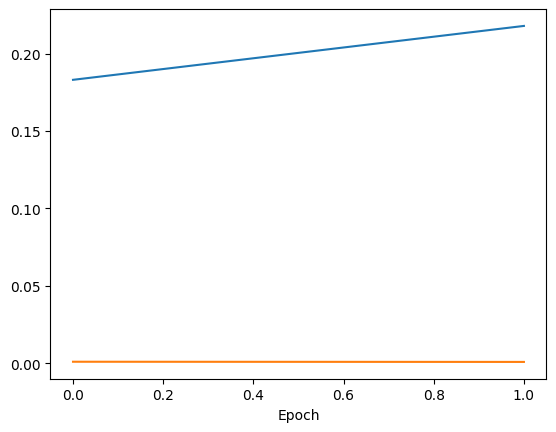

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label = 'MSE')
plt.xlabel('Epoch')

In [2]:
class ConvTasNet(models.Model):
    """
    Full Conv-TasNet model, coded in TensorFlow. I heavily relied upon, upon Jane Wu's TensorFlow implementation (https://github.com/JaneWuNEU/Conv-TasNet-2)
    to get this to work. nplab's and kaituoxu's PyTorch implementations of the model were also instrumental for my understanding of the model.
    
    To explain what the model is doing in the most basic way, it takes a dataset of overlapping chunks of a audio in a waveform format then 
    encodes them using a simple 1D convolution. With this input data, the model is then put through several iterations of downsampling to get 
    features from the data. These features are then turned into separate masks for each target source in the audio data. Finally the masks are 
    applied to the orginal encoded data, which is finally put back into its orginal waveform data format with a Transpose 1D convolution.

    To understand the shape of the data throughout the model, I highly recommend looking at the Parameters class documentation, but I tried to 
    give documentation to the important paramters throughout the layers documentation as well. 
    """
    def __init__(self, param: Parameters):
        super().__init__(name="ConvTasNet")
        self.param = param


        self.encoder = Encoder(self.param)
        self.separator = Separator(self.param)
        self.decoder = Decoder(self.param)

    def call(self, x):
        w = self.encoder(x)
        m_i = self.separator(w)

        decoded = self.decoder(w, m_i)

        return decoded

In [19]:
param = Parameters(naplab_impl=True)

In [20]:
cnn = ConvTasNet(param)
output = cnn(data)

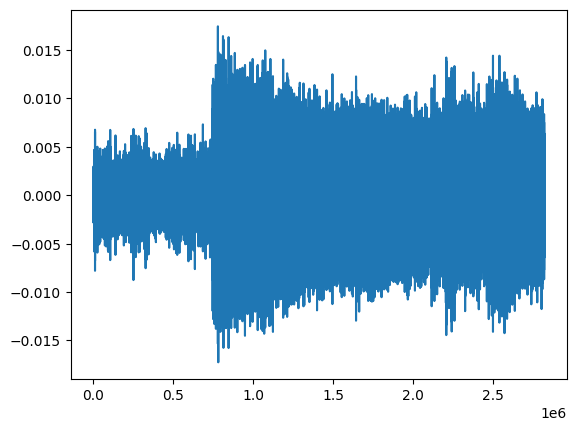

In [13]:
plt.plot(output[0,0,:])

In [11]:
class Encoder(layers.Layer):
    """ 
    First step of model not counting, preprocessing data. Puts the inputs through a 1D Convolutional layer with N output channels. The encoder also includes a activation
    function of a ReLU layer.

    Args: 
        N: Encoder output size
        win: Kernel size of encoder.

    """
    def __init__(self, param: Parameters):
        super(Encoder, self).__init__(name='Encoder')
        self.U = layers.Conv1D(param.N,param.win,strides=param.overlap,activation="relu",use_bias=False, data_format="channels_last")

    def call(self, x): # (M, T)
        batch_count,sample_count = x.shape
        x = tf.reshape(x, (batch_count, sample_count, 1)) # (M, T, 1)
        return self.U(x) # (M, K, N)

        
class Separator(layers.Layer):
    """ 
    To begin the we take the output of the encoder which we then normalize it and feed it into a 1x1Convolution.
    This layer repeats a Temporal Convolution Block multiple times, wherin, what is refered to as a Conv1D Block in the paper, is repeated
    several times for each instance of a Temporal Convolutional Block. Finally the output of the Temporal blocks is input into a 1x1 Convolution
    with C*N output channels.
    Args:
        N: (int) Encoder output size
        B: (int) Bottleneck Conv1DBlock output size
        R: (int) Amount of repeats of the Temporal Convolution block
        X: (int) Amount of times Conv1DBlock is applied in a Temporal Convolution block
        H: (int) Conv1DBlock input size
        C: (int) Amount of sources being estimated
        P: (int) Size of kernel in depthwise convolutions
    
    """
    def __init__(self, param: Parameters):
        super(Separator, self).__init__(name='Separator')
        self.C = param.C
        self.N = param.N
        self.skip=param.skip
        if param.casual:
            self.normalization = cLN(param.N)
        else:
            self.normalization = gLN(param.N) 
        self.bottle_neck = layers.Conv1D(param.B,1)
        
        self.temporal_conv = [TemporalConv(param.X, param.H, param.B, param.P, param.casual, skip=param.skip) for r in range(param.R)]
        self.skip_conn = layers.Add()
        self.prelu = layers.PReLU()
        self.m_i = layers.Conv1D(param.C*param.N, 1)

    def call(self, w): # (M, K, N)
        M, K, _ = w.shape
        normalized_w = self.normalization(w) # (M, K, N)
        output = self.bottle_neck(normalized_w) # (M, K, B)
        skip_list = []
        for i,block in enumerate(self.temporal_conv):
            if self.skip:
                output, skips = block(output)
                skip_list.append(skips)
            else:
                output = block(output)
        # (M, K, B)
        if self.skip:
            output = self.skip_conn(skip_list)

        output = self.prelu(output)
        estimated_masks = self.m_i(output) # (M, K, C*N)
        estimated_masks = activations.sigmoid(tf.reshape(estimated_masks, (M, self.C, K, self.N))) # (M, C, K, N)
        return estimated_masks
    
class Decoder(layers.Layer):
    """ 
    This is layer is final part of the model. Taking the features obtained, from the Conv1D blocks masks are finally combined into with the
    original mix into the estimated sources.

    Args:
        L : (int) length of individual chunks of audio.
    """
    def __init__(self, param: Parameters):
        super(Decoder, self).__init__(name='Decoder')
        self.C = param.C
        self.L = param.L
        self.N = param.N
        self.win = param.win
        self.naplab_impl = param.naplab_impl
        self.overlap = param.overlap

        if not self.naplab_impl:
            self.transpose_conv = layers.Conv1DTranspose(self.L,self.win,strides=param.overlap,use_bias=False)
        else:
            self.transpose_conv = layers.Conv1DTranspose(1,self.win,strides=param.overlap,use_bias=False)

    def call(self, w, m_i): # (M, K, N) (M, C, K, N)
        M,K,_, = w.shape

        w = tf.reshape(tf.repeat(w, 4, axis=0),m_i.shape) # (M, K, N) -> (M, C, K, N)
        output = w * m_i # (M, C, K, N) * (M, C, K, N) 
        output = self.transpose_conv(tf.reshape(output, (M*self.C, K, self.N))) # (M*C, T, 1) or (M*C, T, L)Okay so the official naplab implementation turns the encoded sources directly back into its wavform essentially 
                                                                                # but the kaituoxo one seems to turn it into a 16 channel output then subsetting to only take the first chunk to deal with overlap
        if self.naplab_impl:
            output = output[:,:,:self.overlap]
        output = tf.reshape(output, (M,self.C,-1)) # (M, C, T)
        return output    

In [4]:
def make_base_dataset(M=1,T=320008):
    root_mus = '../MUSDB18'
    mus = musdb.DB(root=root_mus, subsets="train")
    song_list=[]
    for m in range(M):
        track = mus[m]
        audio_l,audio_r = track.audio[:T].T
        song_list.extend([audio_l,audio_r])
    
    return np.array(song_list)

data = make_base_dataset(T = 44100*4)

data.shape


(2, 176400)

In [14]:
x, y = datasets.load_unpack_tensordata()

In [15]:
x_0 = tf.reshape(x[0],(200, 40*16))
x_0.shape

TensorShape([200, 640])

In [3]:
param = Parameters()

In [7]:
param.win // 2
del data

In [19]:
encoder = Encoder(param)
w = encoder(x_0)
w.shape

TensorShape([200, 79, 512])

In [17]:
depthwise = DepthwiseConv(param.H, param.B, param.P, dilation=2, casual=True, skip=param.skip)
convblock = Conv1DBlock(param.H, param.B, param.P, dilation=2, casual=True)


In [20]:
sep = Separator(param)
output = sep(w)

In [41]:
decoder = Decoder(param)
decoded = decoder(w, output)
decoded.shape

Mask multi (200, 4, 79, 512)
transpose conv (800, 640, 1)


TensorShape([200, 4, 640])

In [21]:
output.shape

TensorShape([200, 4, 79, 512])

In [7]:
root_mus = '../MUSDB18'
mus = musdb.DB(root=root_mus, subsets="train")

In [13]:
audio_l,audio_r =mus[0].audio[:320000].T
audio_l.shape

(320000,)

## Overall Architecture

Looking at the model from a top down view, the data follows this pipeline:

Data ---> Encoder ----> Separator ---> Decoder ---> Create Sources

In [ ]:
# Params as globals for testing purposes
M=200
K=40
L=16 # Chunk size
C=4 # Amount of sources being estimated
N=512 # Encoder output size
B=128 # Conv1DBlock output size
H=512 # Conv1DBlock input size
P=3
R=3 # Amount of repeats of the Temporal Convolution block
X=8 # Amount of times Conv1DBlock is applied in a Temporal Convolution block
T=3000 # TODO: figure out how to get this param
dilation = 1
overlap=8
casual=False

In [53]:
class ConvTasNet(models.Model):
    """
    
    """
    def __init__(self,
                 L: int=16, # Chunk size
                 C: int=4, # Amount of sources being estimated
                 N: int=512, # Encoder output size
                 B: int=128, # Conv1DBlock output size
                 H: int=512, # Conv1DBlock input size
                 P: int=3, # Kernel size of Conv1DBlocks
                 R: int=3, # Amount of repeats of the Temporal Convolution block
                 X: int=8, # Amount of times Conv1DBlock is applied in a Temporal Convolution block
                 T: int=3000, # TODO: figure out how to get this param
                 # win: int=2, # Size of encoder-decoder kernels
                 overlap: int=8,
                 skip: bool=True,
                 casual: bool=False
                ):
        super().__init__(name="ConvTasNet")
        self.L = L
        self.C = C
        self.N = N
        self.B = B
        self.H = H
        self.R = R
        self.X = X
        self.T = T
        self.P = P
        # self.win = win
        self.overlap = overlap
        self.skip = skip
        self.casual = casual


        self.encoder = Encoder(self.N)
        self.separator = Separator(self.N, self.B, self.R, self.X, self.H, self.C, self.P, self.casual, self.skip)
        self.decoder = Decoder(self.L)

    def call(self, x):
        w = self.encoder(x)
        m_i = self.separator(w)

        decoded = self.decoder(m_i, w)

        return decoded
    


In [54]:
cnn = ConvTasNet()
cnn_output = cnn(x_batches[0])
cnn_output.shape

TensorShape([200, 4, 40, 16])

In [12]:
# class Encoder(layers.Layer):
#     """ 
#     First step of model not counting, preprocessing data. Puts the inputs through a 1x1 Convolutional layer with N output channels.
#     A 1x1Convolutional layer can be interpreted and implemented as a Dense layer, but I chose not to implement it this way for clarity.
#     The layer also has a ReLU activation function attached to it.

#     Args: 
#         N: Encoder output size

#     """
#     def __init__(self, N):
#         super(Encoder, self).__init__(name='Encoder')
#         self.U = layers.Conv1D(N,1)

#     def call(self, x): # (M, K, L)
#         return self.U(x) # (M, K, N)

        
# class Separator(layers.Layer):
#     """ 
#     To begin the we take the output of the encoder which we then normalize it and feed it into a 1x1Convolution.
#     This layer repeats a Temporal Convolution Block multiple times, wherin, what is refered to as a Conv1D Block in the paper, is repeated
#     several times for each instance of a Temporal Convolutional Block. Finally the output of the Temporal blocks is input into a 1x1 Convolution
#     with C*N output channels.
#     Args:
#         N: (int) Encoder output size
#         B: (int) Bottleneck Conv1DBlock output size
#         R: (int) Amount of repeats of the Temporal Convolution block
#         X: (int) Amount of times Conv1DBlock is applied in a Temporal Convolution block
#         H: (int) Conv1DBlock input size (Maybe should be equal to B*4)
#         C: (int) Amount of sources being estimated
#         P: (int) Size of kernel in depthwise convolutions
    
#     """
#     def __init__(self, N, B, R, X, H, C, P, casual, skip=True):
#         super(Separator, self).__init__(name='Separator')
#         self.C = C
#         self.N = N
#         self.skip=skip
#         if casual:
#             self.normalization = cLN(N)
#         else:
#             self.normalization = gLN(N) 
#         self.bottle_neck = layers.Conv1D(B,1)
        
#         self.temporal_conv = [TemporalConv(X, H, B, P, casual, skip=self.skip) for r in range(R)]
#         self.skip_conn = layers.Add()
#         self.prelu = layers.PReLU()
#         self.m_i = layers.Conv1D(C*N, 1)

#     def call(self, w): # (M, K, N)
#         normalized_w = self.normalization(w) # (M, K, N)
#         output = self.bottle_neck(normalized_w) # (M, K, B)
#         skip_list = []
#         for i,block in enumerate(self.temporal_conv):
#             if self.skip:
#                 output, skips = block(output)
#                 skip_list.append(skips)
#             else:
#                 output = block(output)
#         # (M, K, B)
#         if self.skip:
#             output = self.skip_conn(skip_list)

#         output = self.prelu(output)
#         estimated_masks = self.m_i(output) # (M, K, C*N)
#         M, K, _ = estimated_masks.shape
#         estimated_masks = activations.sigmoid(tf.reshape(estimated_masks, (M, self.C, K, self.N)))
#         return estimated_masks
    
# class Decoder(layers.Layer):
    """ 
    This is layer is final part of the model. Taking the features obtained, from the Conv1D blocks masks are finally combined into with the
    original mix into the estimated sources.

    Args:
        L : (int) length of individual chunks of audio.
    """
    def __init__(self, L):
        super(Decoder, self).__init__(name='Decoder')
        self.L = L
        self.transpose_conv = layers.Conv1DTranspose(L,1)

    def call(self, m_i, w):
        M, C, K, _ = m_i.shape
        est_sources =[]
        for i in range(C):
            source_mask = m_i[:,i,:,:]
            masked_source = w * source_mask
            est_src = self.transpose_conv(masked_source)
            est_sources.append(tf.reshape(est_src, (M, 1, K, L)))

        decoded_outputs = tf.concat(est_sources, axis=1)
        return decoded_outputs            


IndentationError: unexpected indent (1246982919.py, line 72)

In [18]:
class Conv1DBlock(layers.Layer):
    def __init__(self, H, B, P, dilation, casual, skip = True):
        super(Conv1DBlock, self).__init__(name='Conv1DBlock')
        self.skip = skip
        self.input_channels = layers.Conv1D(H,1)
        self.prelu = layers.PReLU()
        if casual:
            self.norm = cLN(H)
        else:
            self.norm = gLN(H)
        
        self.depthwise = DepthwiseConv(H, B, P, dilation, casual, skip=self.skip)

    def call(self, input):
        input_channels = self.input_channels(input)
        input_channels = self.prelu(input_channels)
        input_channels = self.norm(input_channels)
        if self.skip:
            res, skip = self.depthwise(input_channels)
            return res, skip

        res = self.depthwise(input_channels, skip=self.skip)
        return res

class DepthwiseConv(layers.Layer):
    def __init__(self, H, B, P, dilation, casual, skip=True):
        super(DepthwiseConv, self).__init__(name='DepthwiseConv')
        self.skip = skip
        if casual:
            padding_type = "causal"
            self.norm = cLN(H)
        else:
            padding_type = "same"
            self.norm = gLN(H)

        self.conv1d = layers.Conv1D(H, P, dilation_rate=dilation, padding=padding_type, groups=H)
        self.prelu = layers.PReLU()
        
        self.res_out = layers.Conv1D(B, 1)
        if self.skip:
            self.skip_out = layers.Conv1D(B, 1)
    
    def call(self, input):
        input = self.conv1d(input) 
        input = self.prelu(input)
        input = self.norm(input)
        res = self.res_out(input)
        if self.skip:
            skip_out = self.skip_out(input)
            return res, skip_out
        
        return res

class TemporalConv(layers.Layer):
    def __init__(self, X, H, B, P, casual, skip=True):
        super(TemporalConv,self).__init__(name='TemporalConv')
        self.skip=skip
        self.blocks = []
        for i in range(X):
            dilation = 2 ** i
            self.blocks += [Conv1DBlock(H, B, P, dilation, casual, skip=self.skip)]
        self.res_add = layers.Add()
        self.skip_add = layers.Add()
    
    def call(self, block_input):
        skip_list = []
        for block in self.blocks:    
                if self.skip:
                    res, skip = block(block_input)
                    block_input = self.res_add([block_input, res])
                    skip_list.append(skip)
                else:
                    res = block(block_input)
                    block_input = self.res_add([block_input, res])
        if self.skip:
            skip_conn = self.skip_add(skip_list)
            return block_input, skip_conn
        return block_input
        


In [44]:

sep = Separator(param.N,param.B,param.R,param.X,param.H,param.C,param.P,True)

TypeError: __init__() takes 2 positional arguments but 9 were given

In [35]:
dep_res,dep_out = depthwise(w)
print(dep_out.shape, dep_res.shape)


(6, 40000, 128) (6, 40000, 128)


In [40]:
conv_out = convblock(w)
conv_out[0].shape

TensorShape([6, 40000, 128])

In [42]:
temp_out = tempconv(w)
temp_conv.shape

ValueError: Exception encountered when calling layer "TemporalConv" "                 f"(type TemporalConv).

Inputs have incompatible shapes. Received shapes (40000, 512) and (40000, 128)

Call arguments received by layer "TemporalConv" "                 f"(type TemporalConv):
  • block_input=tf.Tensor(shape=(6, 40000, 512), dtype=float32)

In [6]:
def choose_norm(casual, H):
    """ 
    Chooses normalization type based on value of casual.

    Args:
        casual: (bool) chooses type of normalization applied.
    Returns:
        cLN or gLN (layer)
    """
    if casual:
        return cLN(H)
    else:
        return gLN(H)

class cLN(layers.Layer):
    def __init__(self, H, EPS = 1e-8):
        super(cLN, self).__init__(name="cLN")
        self.EPS = EPS
        shape = (1,1,H)
        self.gamma = tf.Variable(tf.ones(shape),trainable=True,shape=shape)
        self.beta = tf.Variable(tf.zeros(shape),trainable=True,shape=shape)

    def call(self, input):
        # (M, K, H)
        E_f = tf.math.reduce_mean(input, axis=2, keepdims=True) # (M, K, 1)
        var = tf.math.reduce_variance(input, axis=2, keepdims=True)# (M, K, 1)

        normalized = self.gamma * (input - E_f) / tf.math.sqrt(var + self.EPS) + self.beta
        # (M, K, H)
        return normalized
    
class gLN(layers.Layer):
    def __init__(self, H, EPS = 1e-8):
        super(gLN, self).__init__(name="gLN")
        self.EPS = EPS
        shape = (1,1,H)
        self.gamma = tf.Variable(tf.ones(shape),trainable=True,shape=shape)
        self.beta = tf.Variable(tf.zeros(shape),trainable=True,shape=shape)

    def call(self, input):
        # (M, K, H)
        E_f = tf.math.reduce_mean(input, axis=(1,2), keepdims=True) # (M, 1, 1)
        var = tf.math.reduce_variance(input, axis=(1,2), keepdims=True)# (M, 1, 1)

        normalized = self.gamma * (input - E_f) / tf.math.sqrt(var + self.EPS) + self.beta
        # (M, K, H)
        return normalized


In [26]:
def show_norm(input):
    fig, axes = plt.subplots(1,3, figsize=(12, 4))

    norm_c = cLN(H)(input)
    norm_g = gLN(H)(input)

    axes[0].set_title("Not normalized")
    axes[0].plot(input[0][0])

    axes[1].set_title("Casual normalization")
    axes[1].plot(norm_c[0][0])

    axes[2].set_title("Global normalization")
    axes[2].plot(norm_g[0][0])


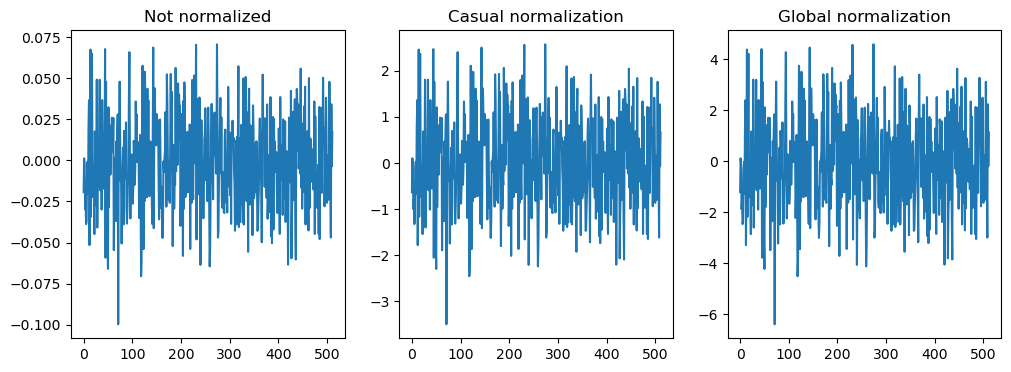

In [30]:
show_norm(test_encoded)